# BrainHack 2022
-----------------------------
Jenny Lunde

## Import and explore data

In [102]:
import pandas as pd
from sklearn import decomposition, preprocessing, linear_model
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [27]:
group_T1w = pd.read_csv("../MR-ART_mriqc1/group_T1w.tsv", "\t") # load mriqc data
scores = pd.read_csv("../scores.tsv", "\t") # load manual scores

C:\Users\jenny\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# remove irrelevant columns
group_T1w = group_T1w.drop(['spacing_x', 'spacing_y', 'spacing_z', 'size_x', 'size_y', 'size_z'], axis = 1) 

In [4]:
columns = group_T1w.columns # save column names

## Preprocesing data

In [174]:
data = group_T1w.to_numpy()[:,1:] # Change to numpy arrays, and remove bids_name

In [6]:
num_rows = len(data) 

# split data into train and test set
train_data = data[0:int(num_rows*0.7)]
test_data = data[int(num_rows*0.7):]

In [7]:
# Normalize data
scaler = preprocessing.StandardScaler()
scaler.fit(train_data)
normalized_train_data = scaler.transform(train_data)

In [8]:
def name_to_movementscore(name):
    """
    Gives rating based on head movement
    1: no movement
    2: some movement
    3: moves a lot
    """
    if "standard" in name:
        return 1
    elif "headmotion1" in name:
        return 2
    elif "headmotion2" in name:
        return 3
    else:
        raise Exception(f"Movement score not found in {name}")

## Factor Analysis

In [9]:
# use sklearns Factor Analysis
# n_components are the number of factors (no reason for choosing 5)
# random state sets the seed to have reprodusable data
transformer = decomposition.FactorAnalysis(n_components=5, random_state=0)
data_transformed = transformer.fit_transform(normalized_train_data)

In [10]:
data_transformed.shape

(305, 5)

In [11]:
loadings = transformer.components_ # loadings are the weights for each factor

## Visualization of results

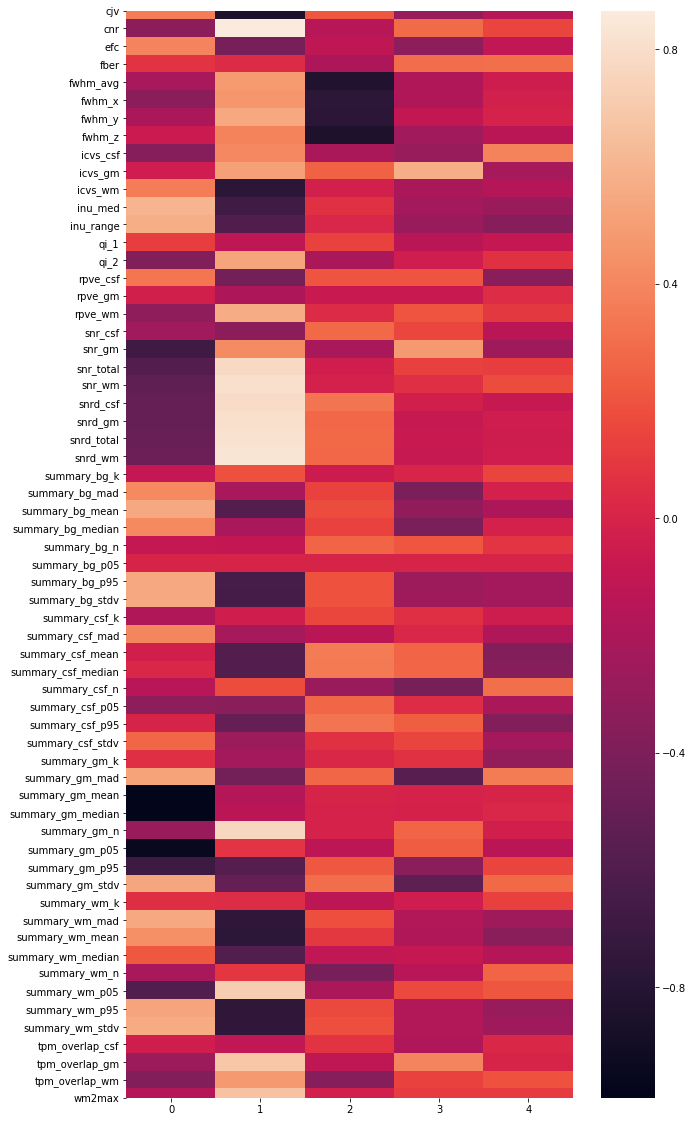

In [12]:
# Make heatmap over factor components
fig, ax = plt.subplots(figsize=(10,20)) 
seaborn.heatmap(loadings.T[:,:], yticklabels=columns[1:])

## Try to find features that can explain MRI quality

In [13]:
# Features that has a low weight (absolute value) for all components are set to be unimportant (low: between -0.4 and 0.4)
unimportand_features = []
for i in range(len(loadings.T)):
    row = loadings.T[i]
    if all(r>-0.4 and r<0.4 for r in row):
        unimportand_features.append(columns[1:][i])
        
# Features that has a low weight (absolute value) for all components are set to be medium important (low: between -0.8 and 0.8)
medium_features = []
for i in range(len(loadings.T)):
    row = loadings.T[i]
    if all(r>-0.8 and r<0.8 for r in row):
        if columns[1:][i] in unimportand_features:
            continue
        medium_features.append(columns[1:][i])

In [161]:
print("Unimportant: " + ", ".join(unimportand_features) + "\n\nMedium important" + ", ".join(medium_features))

Unimportant: fber, qi_1, rpve_gm, snr_csf, summary_bg_k, summary_bg_n, summary_bg_p05, summary_csf_k, summary_csf_p05, summary_csf_stdv, summary_gm_k, summary_wm_k, tpm_overlap_csf

Medium importantefc, fwhm_x, fwhm_y, icvs_csf, icvs_gm, icvs_wm, inu_med, inu_range, qi_2, rpve_csf, rpve_wm, snr_gm, snr_total, snrd_csf, summary_bg_mad, summary_bg_mean, summary_bg_median, summary_bg_p95, summary_bg_stdv, summary_csf_mad, summary_csf_mean, summary_csf_median, summary_csf_n, summary_csf_p95, summary_gm_mad, summary_gm_n, summary_gm_p95, summary_gm_stdv, summary_wm_mad, summary_wm_mean, summary_wm_median, summary_wm_n, summary_wm_p05, summary_wm_p95, summary_wm_stdv, tpm_overlap_gm, tpm_overlap_wm, wm2max


In [15]:
# The rest of the freatures are set as important
important = []
indexes = []
i = 0
for element in columns[1:]:
    if element not in unimportand_features and element not in medium_features:
        indexes.append(i)
        important.append(element)
    i += 1

In [163]:
print("Important: " + ", ".join(important))

Important: cjv, cnr, fwhm_avg, fwhm_z, snr_wm, snrd_gm, snrd_total, snrd_wm, summary_gm_mean, summary_gm_median, summary_gm_p05


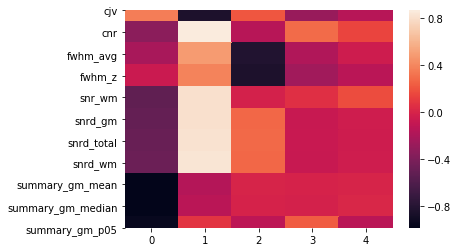

In [17]:
# Make heatmap of important features for each factor. Looking for features that are highly correlated
seaborn.heatmap(loadings.T.take(indexes, 0), yticklabels=important)

In [165]:
# using the features that are important, but removing features that are highly correlated with another feature
use = ['cjv',
 'cnr',
 'fwhm_avg',
 'snr_wm',
 'snrd_total',
 'summary_gm_median',
 'summary_gm_p05']

In [166]:
# scale the data
use_data = preprocessing.StandardScaler().fit_transform(group_T1w[use])

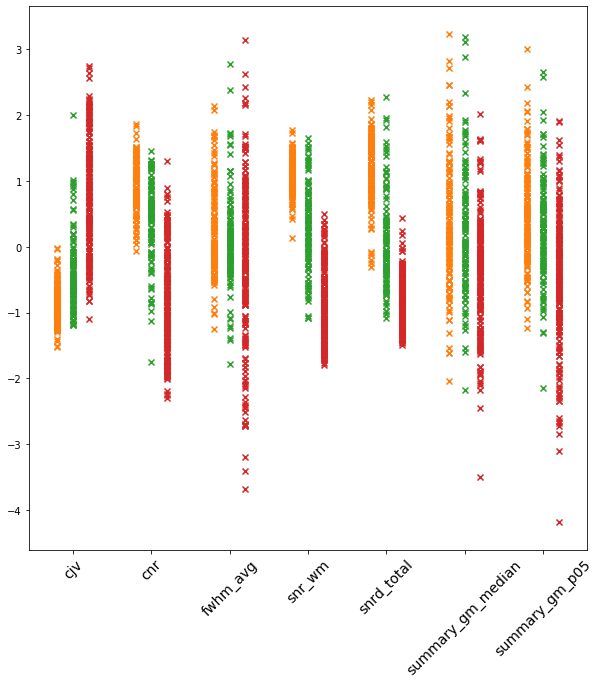

In [167]:
# make a plot of the normalized values for the important features, and color them based on the score given manualy

x_axis = np.array([1,2,3,4,5,6,7])

plt.figure(figsize = (10, 10))
for i in range(len(use_data)):
    name = group_T1w.loc[i][0]
    row = use_data[i]
    color = int(scores[scores['bids_name'] == name]['score'])
    plt.scatter(x_axis + color*0.2 - 0.4, row, color = f'C{color}', marker = "x")
    plt.xticks(x_axis, list(use), rotation = "45", fontsize=14)
plt.show()

Most of the features chose seem to have some correlation with the score given, but the good, medium or bad scores are still mostly overlapping. fwhm_avg seems to have little to no correlation. 

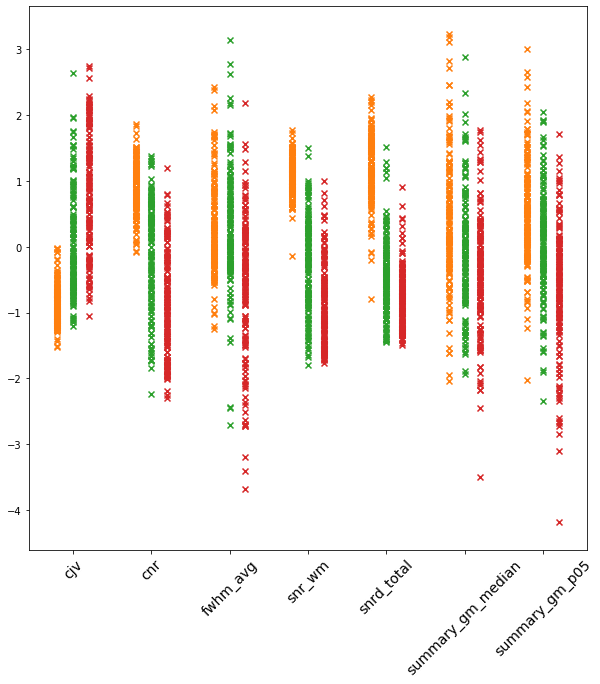

In [168]:
# redo the previous plot, but with headmovement as color code
x_axis = np.array([1,2,3,4,5,6,7])

plt.figure(figsize = (10, 10))
for i in range(len(use_data)):
    name = group_T1w.loc[i][0]
    row = use_data[i]
    color = name_to_movementscore(name)
    plt.scatter(x_axis + color*0.2 - 0.4, row, color = f'C{color}', marker = "x")
    plt.xticks(x_axis, list(use), rotation = "45", fontsize=14)
plt.show()

The difference between headmovement and score is minimal. I will continue with using score as it is evaluated by professionals, while headmovment can vary from each individual.

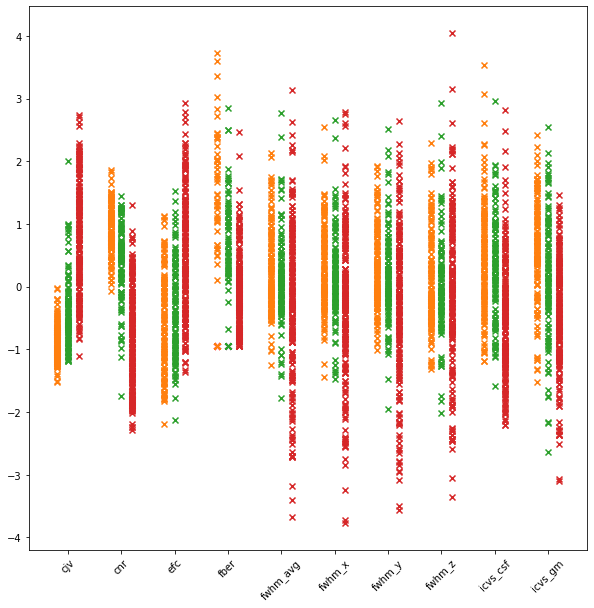

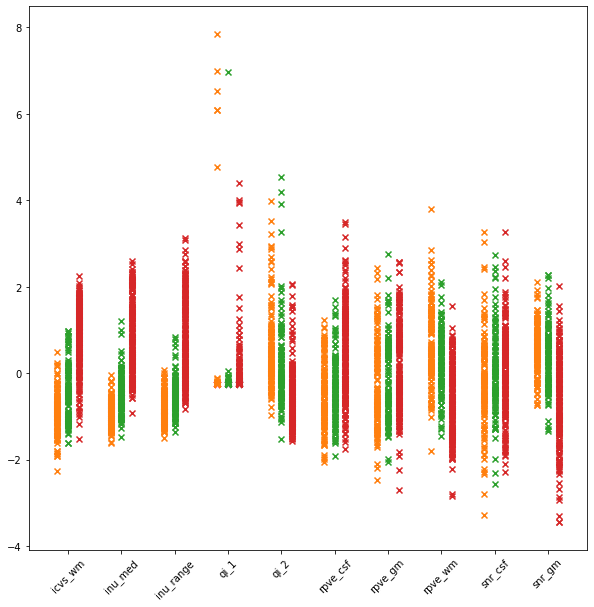

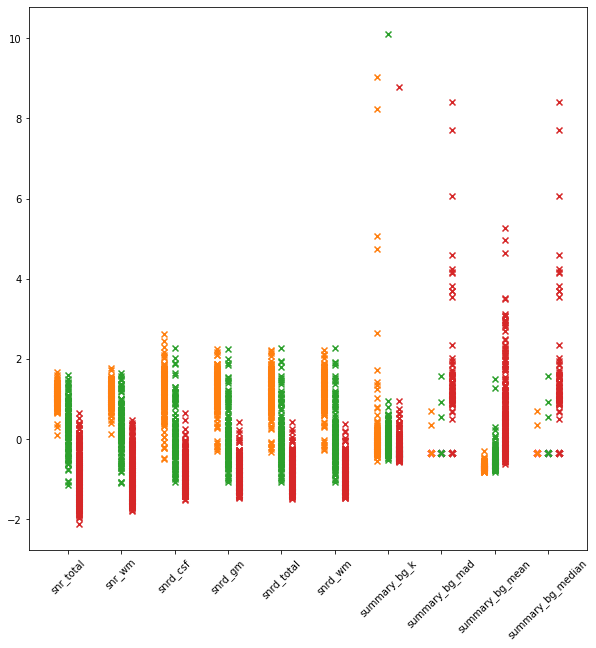

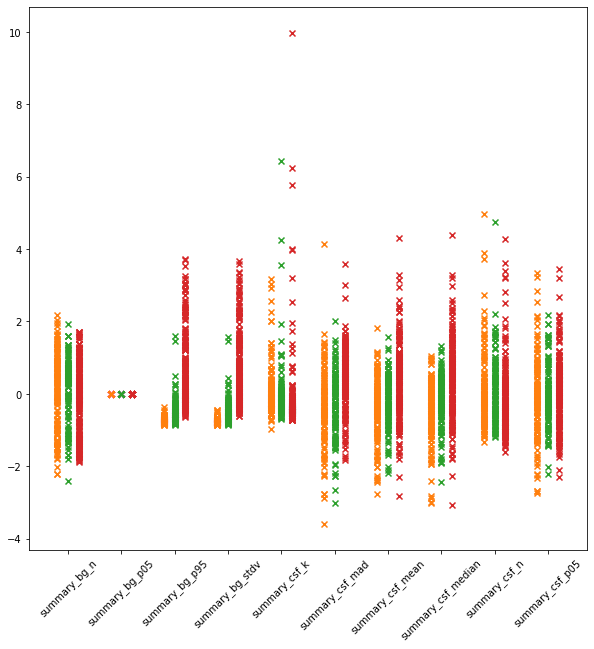

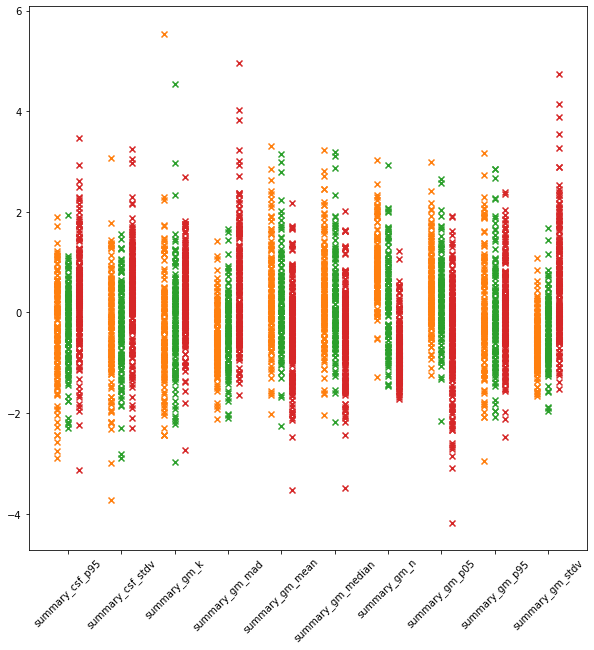

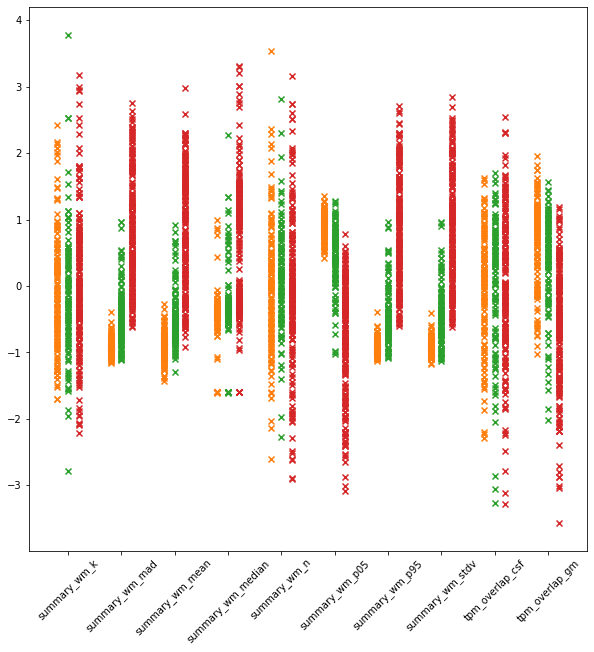

ValueError: x and y must be the same size

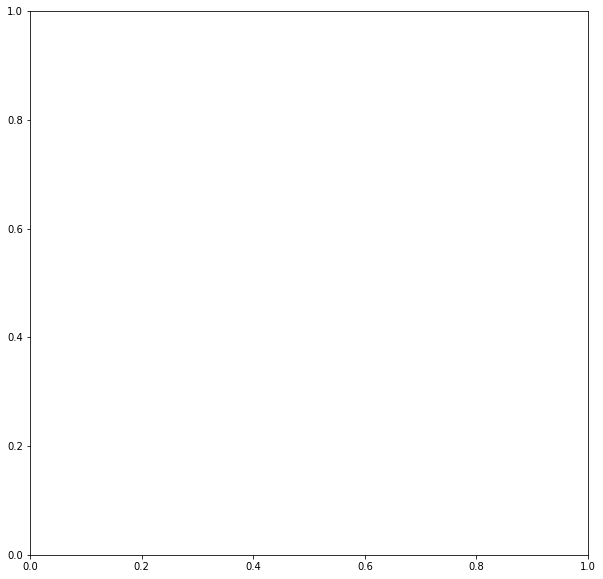

In [171]:
# Do the same plot, but for all features
for i in range(7):
    try:
        use = columns[1:][i*10:(i+1)*10]
        x_axis = np.array([1,2,3,4,5,6,7,8,9,10])
    except:
        use = columns[1:][i*10:]
        x_axis = np.arange(len(use))
        
    use_data = preprocessing.StandardScaler().fit_transform(group_T1w[use])

    plt.figure(figsize = (10, 10))
    for i in range(len(use_data)):
        name = group_T1w.loc[i][0]
        row = use_data[i]
        color = int(scores[scores['bids_name'] == name]['score'])
        plt.scatter(x_axis + color*0.2-0.4, row, color = f'C{color}', marker = 'x')
    plt.xticks(x_axis, list(use), rotation = "45")
    plt.show()

In [175]:
# Do a similar plot, but with the factors as x-axis
all_data_transformed = transformer.fit_transform(data)
all_data_transformed.shape

(436, 5)

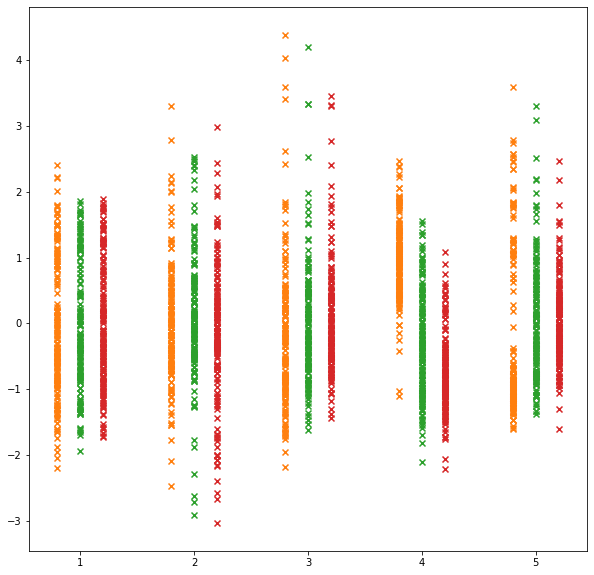

In [177]:
x_axis = np.array([1,2,3,4,5])

plt.figure(figsize = (10, 10))
for i in range(len(all_data_transformed)):
    name = group_T1w.loc[i][0]
    row = all_data_transformed[i]
    color = name_to_movementscore(name)
    plt.scatter(x_axis + color*0.2 - 0.4, row, color = f'C{color}', marker = 'x')
plt.show()

The factors show less correlation to the score compared to individual features. Only the 4th factor seems to have some correlation.

## Try to do linear regression
Did not work...

In [71]:
y = np.zeros(len(scores))
X = np.zeros((len(scores), len(['cjv',
 'cnr',
 'fwhm_avg',
 'snr_wm',
 'snrd_total',
 'summary_gm_median',
 'summary_gm_p05'])))

for i in range(len(scores)):
    y[i] = (int(scores[scores['bids_name'] == group_T1w.loc[i]['bids_name']]['score']))
    X[i] = group_T1w.loc[i][['cjv',
 'cnr',
 'fwhm_avg',
 'snr_wm',
 'snrd_total',
 'summary_gm_median',
 'summary_gm_p05']]
    
print(X.shape)

reg = linear_model.LinearRegression().fit(X[0:int(0.7*len(y))], y[0:int(0.7*len(y))])

(436, 7)


In [72]:
pred = reg.predict(X[0:int(0.7*len(y))])

correct = 0
for i in range(len(pred)):
    prediciton = int(pred[i])
    manual = scores['score'].to_numpy()[i]
    if prediciton == manual:
        correct += 1
print(len(pred))
print(correct)

305
92


## Try to maually combine features
Here I tried to look for features that correlate with the score, by looking at the previous plots.

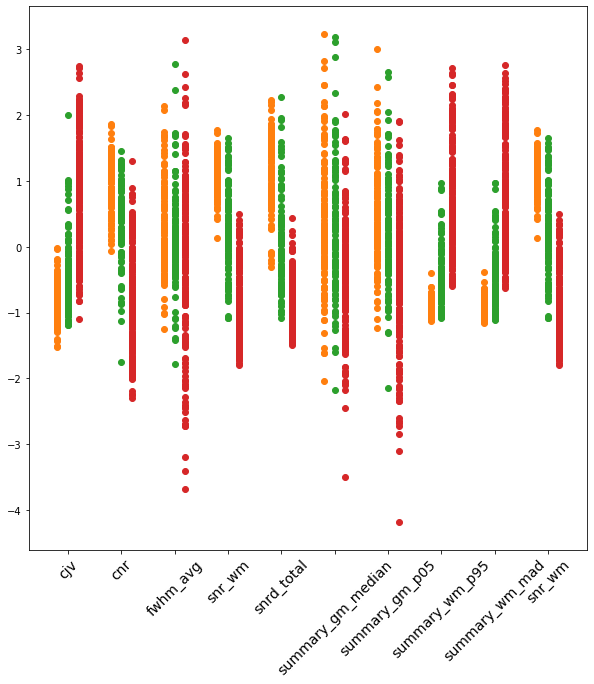

In [178]:
use = ['cjv',
 'cnr',
 'fwhm_avg',
 'snr_wm',
 'snrd_total',
 'summary_gm_median',
 'summary_gm_p05',
 'summary_wm_p95',
 'summary_wm_mad',
 'snr_wm']

use_data = preprocessing.StandardScaler().fit_transform(group_T1w[use])

x_axis = np.arange(len(use))

plt.figure(figsize = (10, 10))
Y_vals = np.zeros(len(group_T1w))

dct = {}
for u in use:
    dct[u + "1"] = []
    dct[u + "2"] = []
    dct[u + "3"] = []


for i in range(0, len(use_data)):
    name = group_T1w.loc[i][0]
    row = use_data[i]
    color = int(scores[scores['bids_name'] == name]['score'])
        
    for j in range(len(row)):
        dct[use[j] +  str(color)].append(row[j])
    
    plt.scatter(x_axis + color*0.2 - 0.4, row, color = f'C{color}')
    plt.xticks(x_axis, list(use), rotation = "45", fontsize=14)
plt.show()

C:\Users\jenny\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


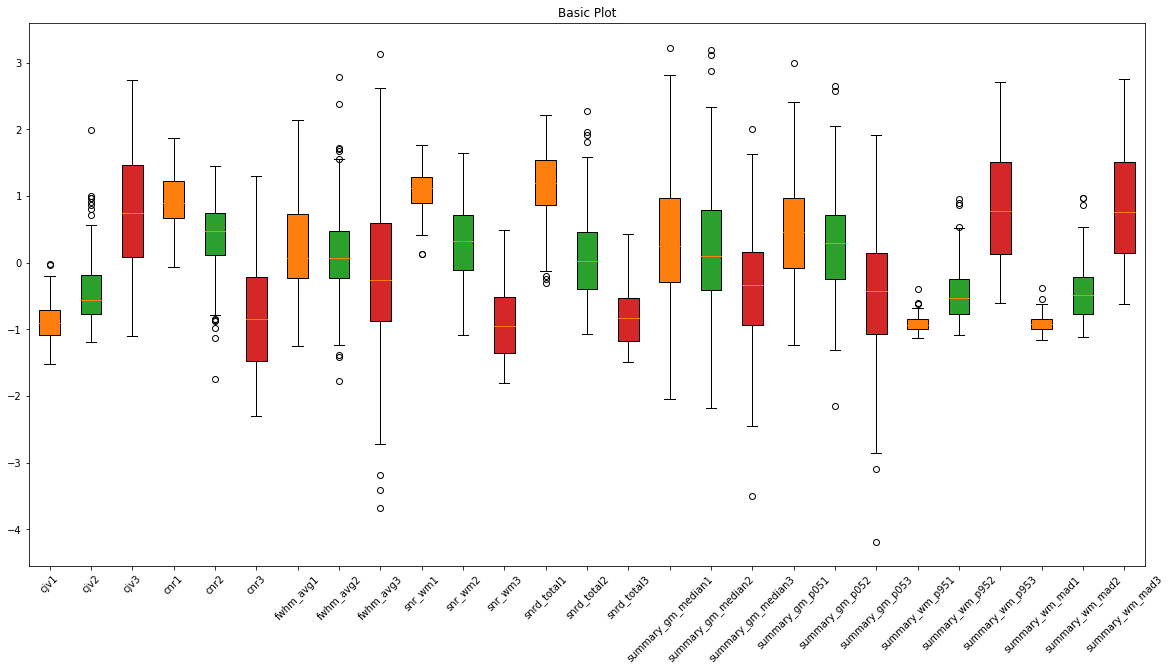

In [179]:
fig1, ax1 = plt.subplots(figsize = (20,10))
ax1.set_title('Basic Plot')

data = []
for l in dct:
    data.append(dct[l])

bplot = ax1.boxplot(data,  patch_artist=True, labels = list(dct.keys()))
                    
i = 1
for patch in bplot['boxes']:
    patch.set_facecolor(f'C{i}')
    i +=1
    if i>3:
        i =1
plt.xticks(rotation = 45)
plt.show()

Boxplot for selected features. The number in the xlabel corresponds to the score given by professionals (from the score dataset).

In [180]:
# Try to use features that well seperates good and bad scores
summed = -use_data[:,7] + use_data[:,9] + use_data[:,3] + use_data[:,4]

In [181]:
labels = ["Score 1", "Score 2", "Score 3"]
dct2 = {}
for l in labels:
    dct2[l] = []
    
    
for i in range(len(summed)):
    name = group_T1w.loc[i][0]
    #print(scores[scores['bids_name'] == name])
    color = int(scores[scores['bids_name'] == name]['score'])
    
    dct2[f"Score {color}"].append(summed[i])
    
    #plt.scatter(color*0.2 - 0.4, summed[i], color = f'C{color}')
    #plt.xticks(x_axis, list(use), rotation = "45", fontsize=14)

#plt.grid()
#plt.plot()

C:\Users\jenny\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


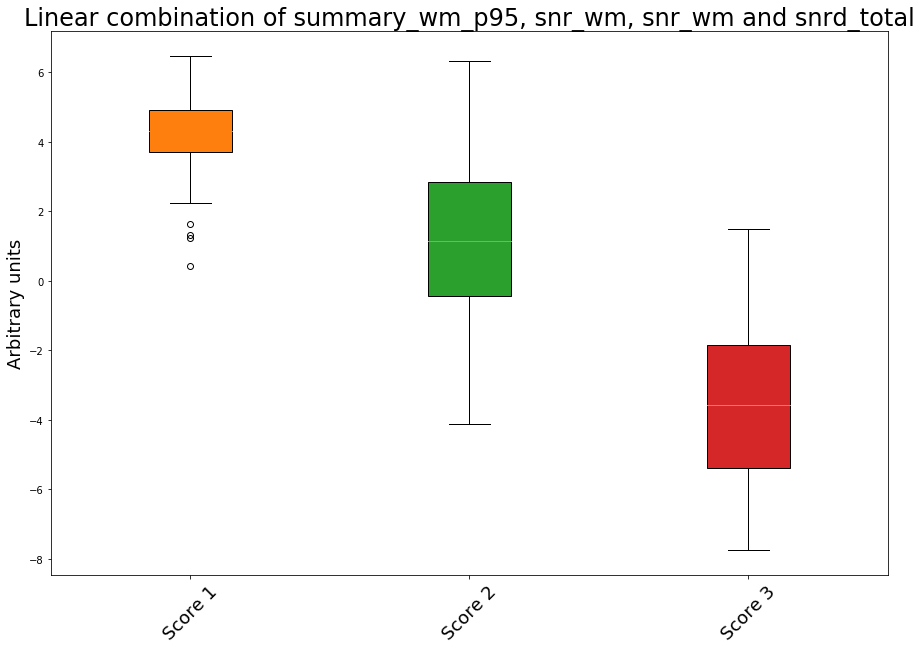

In [183]:
fig1, ax1 = plt.subplots(figsize = (15,10))
ax1.set_title('Basic Plot')

data = []
for l in dct2:
    data.append(dct2[l])

bplot = ax1.boxplot(data,  patch_artist=True, labels = labels)
                    
i = 1
for patch in bplot['boxes']:
    patch.set_facecolor(f'C{i}')
    i +=1
    if i>3:
        i =1
        
plt.title("Linear combination of summary_wm_p95, snr_wm, snr_wm and snrd_total", fontsize = 24)
plt.xticks(rotation = 45, fontsize = 18)
plt.ylabel("Arbitrary units", fontsize = 18)
plt.savefig("Linear_comb_boxplot.png")
plt.show()

This linear combination seems to seperate the three different scores fairly well. Score 2 is overlappin with both score 1 and 2.

In [92]:
# Try to use features that well seperates good and bad scores
summed = use_data[:,3] + use_data[:,4]  

[]

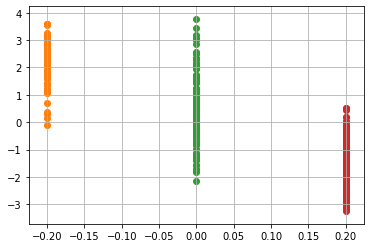

In [93]:
for i in range(len(summed)):
    name = group_T1w.loc[i][0]
    #print(scores[scores['bids_name'] == name])
    color = int(scores[scores['bids_name'] == name]['score'])
    plt.scatter(color*0.2 - 0.4, summed[i], color = f'C{color}')
    #plt.xticks(x_axis, list(use), rotation = "45", fontsize=14)
plt.grid()
plt.plot()

In [47]:
summed = -use_data[:,0] + use_data[:,1]

[]

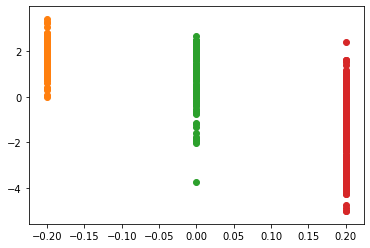

In [48]:
for i in range(len(summed)):
    name = group_T1w.loc[i][0]
    #print(scores[scores['bids_name'] == name])
    color = int(scores[scores['bids_name'] == name]['score'])
    plt.scatter(color*0.2 - 0.4, summed[i], color = f'C{color}')
    #plt.xticks(x_axis, list(use), rotation = "45", fontsize=14)
plt.plot()